## Physics-Informed Neural Networks for 1D Burgers Equation

### Introduction

Physics-Informed Neural Networks (PINNs), introduced by *Raissi et al. (2019)*, represent a transformative approach that seamlessly integrates physical laws into the training of neural networks. Unlike traditional neural networks that rely solely on data-driven methodologies, PINNs leverage the underlying governing equations (such as partial differential equations) directly within the loss function of the network.

The central idea behind PINNs is to encode known physical constraints into the neural network's optimization process (basically the loss function), enabling the network not only to fit observational data but also to adhere closely to the underlying physics of the problem. This approach results in neural networks that are inherently consistent with physical laws, making PINNs highly effective in scenarios where data might be sparse or noisy.

PINNs have found applications across various scientific and engineering domains, including fluid dynamics, solid mechanics, quantum mechanics, and more. Their primary advantage is the ability to yield physically accurate predictions with fewer or (no observed) training data points and improved interpretability.

In general, PINNs are unsupervised, but they can be augmented with available data. However, employing PINNs also introduces specific challenges, such as ensuring adequate convergence during training, balancing the contribution of data-fitting (if data is present) and physics-based losses, and managing the computational complexity associated with evaluating the governing equations.

In this notebook, we will demonstrate the practical implementation of PINNs using Pytorch Ligtning.

In [1]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
from pyDOE import lhs

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
NVIDIA RTX A6000


### Problem Setup

We consider the Burgers equation in one-dimension, which is a quasi-linear parabolic partial differential equation given as:
\begin{equation}
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \qquad 0 < x < 1, t > 0,
\end{equation}
with initial condition
$$
    u(x,0) = sin(\pi x), \qquad 0< x < 1,
$$
and (homogenous) boundary conditions  
$$
    u(0,t) =  u(1,t) = 0,  \qquad t > 0.
$$

> Note: The exact solution of the above Burger's equation can be obtained using the Hopf-Cole transformation, that transforms the equation into a linear heat equation.

To solve using PINNs, define a residual $f(t, x)$ as:
\begin{equation}
f := \frac{\partial u_{\theta}}{\partial t} + u_{\theta} \frac{\partial u_{\theta}}{\partial x} - \nu \frac{\partial^2 u_{\theta}}{\partial x^2},
\end{equation}
where $ u_{\theta}(x, t)$ is the velocity in the Burgers equation, now represented as a neural network (i.e is the output of a neural network).

**Our goal is to let $f \approx 0 $, so that our neural network output $u_{\theta}$ will satisfy the Burgers equation (thus, a solution!!).**

What makes a PINN different from a vanilla neural network is basically the loss function. In a PINN, the neural network parameters are trained by minimizing a composite loss function:
$$
MSE = MSE_u + MSE_f,
$$
where
$$
MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}\left| u_{\theta}(t_u^i, x_u^i) - u^i \right|^2,
$$
and,
$$
MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}\left| f(t_f^i, x_f^i) \right|^2.
$$

In this formulation:

* $ (t_u^i, x_u^i, u^i)$ are observed data points with known values of the solution $ u $, such as the boundary points and/or data from a dataset (or exeperiments).

* $ (t_f^i, x_f^i)$ are collocation points used to enforce the differential equation residual $ f(t,x) \approx 0 $.

> How do we compute the derivatives required for evaluating $ f(t,x) $? They are computed using automatic differentiation (or some known numerical differencing techniques, though this is less common), enabling the simultaneous enforcement of data-fitting and physical constraints.

> In this Notebook, we take $\nu = 1e-2$


### Configuration and Data Generation

In [2]:
class config:
  def __init__(self):
    #The training parameters
    self.nu = 1e-2
    self.x0 = 0  #x0 :Left boundary point
    self.xf = 1  #xf (x final): Right boundary point
    self.layers = [2,125, 256, 125, 1]
    self.spatial_resolution =  300
    self.temporal_resolution = 150

    #Defining the initial condition
    self.init_cond = lambda x: torch.sin(torch.pi * x) 
    self.col_pts = 10000 #Number of collocation points (points in the domain to train on)
    self.batch_size = 1000
    self.num_epoch = 1000

    self.lr = 1e-3

    
    self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/pinn_burgers_model1d.pt'
    self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_burgers1d_pinn'


cfg = config()

In [3]:
def dfx(f, x):
    gouts = torch.ones_like(f)  # To ensure it matches shape of output f
    return grad(f, x, grad_outputs=gouts, create_graph=True)[0]

In [4]:
def prepare_data(cfg):
    x = torch.linspace(cfg.x0, cfg.xf, cfg.col_pts//4).view(-1,1).float()
    t = torch.linspace(0, 1, cfg.col_pts//4).view(-1,1).float()
    #We will be training on random points inside the domain Omega = (0,1) x (0,1), and on the boundary and initial points
    #The points inside the domain will be generated randomly using Latin Hypercube Sampling
    lower_bound = torch.tensor([cfg.x0,0.]); upper_bound = torch.tensor([cfg.xf,1.])
    print(f"The boundary points are: {lower_bound} and {upper_bound}")

    x_inner = lower_bound + (upper_bound - lower_bound)*torch.tensor(lhs(2,cfg.col_pts)).float()
    cfg.x_inner = x_inner
    print(f"Shape of training points inside the domain: {x_inner.shape} ")

    #Next we have to generate the boundary and initial coordinate points, and their corresponding solution u
    #1) The initial condition u(x,0) = sin(pi * x)
    x_initial = torch.cat((x,torch.zeros_like(x)), dim = 1) #All possible initial points at time t = 0
    u_init = cfg.init_cond(x)

    #2) The left boundary condition u(0,t) = 0
    x_bound_left = torch.cat((torch.zeros_like(t), t), dim = 1)
    u_bound_left = torch.zeros_like(t)


    #3) The right boundary condition u(1,t) = 0
    x_bound_right = torch.cat((torch.ones_like(t), t), dim = 1)
    u_bound_right = torch.zeros_like(t)

    #We need to stack all these boundary and initial points vertically. We can randomly pick some for training if we wish
    x_bound = torch.cat((x_initial, x_bound_left, x_bound_right), dim = 0)
    u_bound = torch.cat((u_init, u_bound_left, u_bound_right), dim = 0)
    print(f"Shape of total boundary points: {x_bound.shape}")

    #Randomize the collocation poiints,
    idx = torch.randperm(x_bound.shape[0])
    cfg.x_bound_random=x_bound[idx].to(device)
    cfg.u_bound_random =u_bound[idx].to(device)
    print(f"Shape of boundary points for training: {x_bound[idx].shape}")

    #Since the boundary points need to also satisfy the PDE, we can combine it to make a complete training data. Though, it is not necessary
    x_train = torch.cat((x_bound[idx,:], x_inner), dim = 0)
    print(f"Final shape of training data: {x_train.shape} ")

    #Finally, we create the dataloader
    train_loader = DataLoader(x_train, batch_size=cfg.batch_size, shuffle=True)

    return train_loader

In [5]:
#We can visualize the data to understand them clearly
def for_visuals(cfg):
    x = torch.linspace(cfg.x0,cfg.xf, 20).view(-1,1)
    t = torch.linspace(0,1, 20).view(-1,1)
    lower_bound = torch.tensor([0.,0.]); upper_bound = torch.tensor([1.,1.])
    x_inner = lower_bound + (upper_bound - lower_bound)*torch.tensor(lhs(2,400)).float()
    x_bound_left = torch.cat((torch.zeros_like(t), t), dim = 1)
    x_bound_right = torch.cat((torch.ones_like(t), t), dim = 1)
    x_initial = torch.cat((x,torch.zeros_like(x)), dim = 1)
    x_bound = torch.cat((x_initial, x_bound_left, x_bound_right), dim = 0)
    return x_bound, x_inner
x_bound, x_inner = for_visuals(cfg)

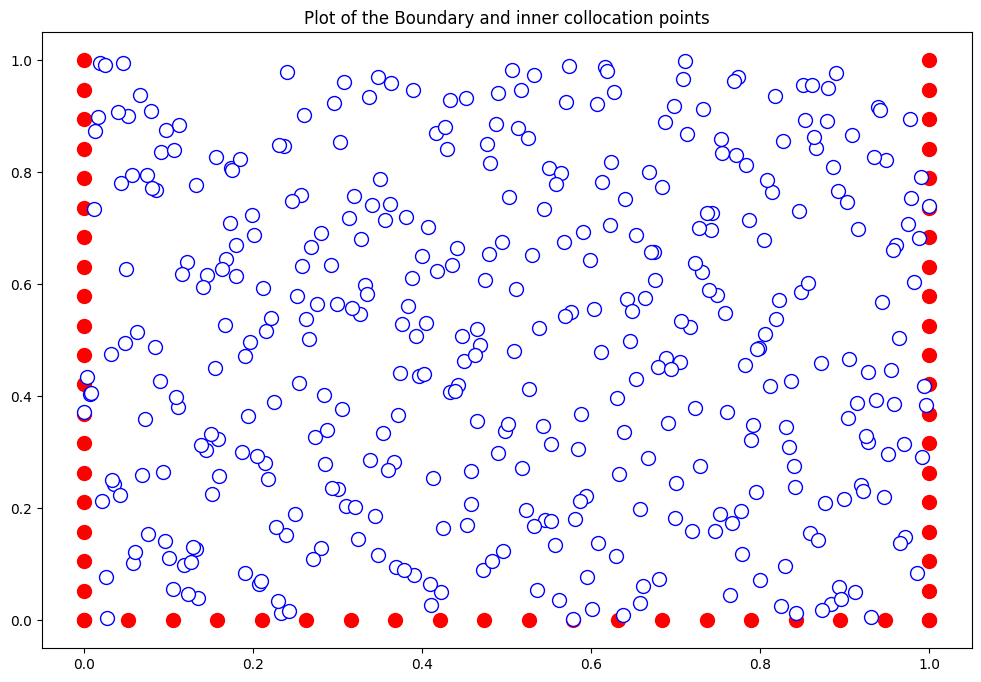

In [6]:
%matplotlib inline
plt.figure(figsize = (12,8))
plt.title("Plot of the Boundary and inner collocation points")
plt.scatter(x_bound[:,0], x_bound[:,1],  marker='o', s=100, c='r')
plt.scatter(x_inner[:,0], x_inner[:,1],  marker='o', s=100,color = 'white', edgecolors = 'blue')
plt.show()

In [7]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None

    def setup(self, stage = None):
        self.train_loader = prepare_data(self.cfg)
        print('DataLoaded Successfully!!')

    def train_dataloader(self):
        return self.train_loader

data_module = DataModule(cfg)

In [8]:
#It is perfectly normal to have testing data way more than the training data in a PINN.
#Another common approach is to generate random points for every iteration, which we did not do here, but can be implemented easily
data_module.setup()

The boundary points are: tensor([0., 0.]) and tensor([1., 1.])
Shape of training points inside the domain: torch.Size([10000, 2]) 
Shape of total boundary points: torch.Size([7500, 2])
Shape of boundary points for training: torch.Size([7500, 2])
Final shape of training data: torch.Size([17500, 2]) 
DataLoaded Successfully!!


### The PINN Training

In [9]:
#first we define our NN module
class PINN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation = nn.Tanh()
        self.layers = cfg.layers #The number of layers

        #Defining the linear layers
        self.linears = self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)])
        #Initializing the weights
        for i in range(len(self.layers)-1):
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
          nn.init.zeros_(self.linears[i].bias.data)

    def forward(self,x):
        a = x.float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

In [10]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = PINN(cfg)
        self.Loss = nn.MSELoss()
        self.metrics = {'train_loss':[]}
        

    def forward(self,x):
        return self.model(x)

    def PDEloss(self, batch):
        x = batch
        g = x.clone()
        g.requires_grad = True #For Automatic differentiation
        u_hat = self.forward(g) #The forward pass
        d_u_hat = dfx(u_hat,g)#First derivative
        d2_u_hat = dfx(d_u_hat,g)#second derivative
        u_hat_t = d_u_hat[:,[1]]; u_hat_x = d_u_hat[:,[0]]; u_hat_xx = d2_u_hat[:,[0]] #Note that: 0 for x, 1 for t
        res = u_hat_t + u_hat*u_hat_x - self.cfg.nu * u_hat_xx #The Burgers equation
        loss = self.Loss(res.float(), torch.zeros_like(res).float())
        return loss

    def boundary_loss(self):
        x = self.cfg.x_bound_random
        u = self.cfg.u_bound_random
        u_hat = self(x)
        assert u_hat.shape == u.shape, f"Shape Mismatch! prediction shape:{u_hat.shape}, target shape: {u.shape}"
        loss = self.Loss(u.float(),u_hat.float())
        return loss

    def training_step(self, batch):
        loss_pde = self.PDEloss(batch)
        loss_bound = self.boundary_loss()
        train_loss = loss_pde + loss_bound
        self.log('train_loss', train_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(train_loss.item())
        return train_loss

    def predict_step(self, batch):
        x = batch
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr)
        return [optimizer]
    

    #def evaluate_on_test_set(self, loader):
    #    self.eval()
    #    predictions = []
#
    #    with torch.no_grad():
    #        for batch in loader:
    #            x = batch
    #            x = x.to(self.device)
    #            y_hat = self(x)
    #            predictions.append(y_hat.cpu())
    #    return predictions  

In [11]:
#Training the model
model = PlModel(cfg)

checkpoint_callback = ModelCheckpoint(
    monitor = 'train_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'pinn_burgers_1d-{epoch:02d}-{train_loss:.5f}',
    save_top_k = 1,
    mode = 'min',
    save_weights_only = True
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True,
    deterministic = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\checkpoint_burgers1d_pinn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | PINN    | 64.9 K | train
1 | Loss  | MSELoss | 0      | train
------------------------------------------
64.9 K    Trainable params
0       

The boundary points are: tensor([0., 0.]) and tensor([1., 1.])
Shape of training points inside the domain: torch.Size([10000, 2]) 
Shape of total boundary points: torch.Size([7500, 2])
Shape of boundary points for training: torch.Size([7500, 2])
Final shape of training data: torch.Size([17500, 2]) 
DataLoaded Successfully!!


c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
`Trainer.fit` stopped: `max_epochs=1000` reached.


### Evaluation

In [12]:
#First load best model in the checkpoint
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("pinn_burgers_1d-*.ckpt"))[-1]
model_best = PlModel.load_from_checkpoint(checkpoint_path, cfg=cfg)

In [13]:
#Generating the test data
x_grid = torch.linspace(cfg.x0,cfg.xf, cfg.spatial_resolution).view(-1,1).float()
t_grid = torch.linspace(0,1, cfg.temporal_resolution).view(-1,1).float()
#We can create a meshgrid of all possible points for our test data
X,T = torch.meshgrid(x_grid.squeeze(1),t_grid.squeeze(1), indexing='xy')
#Next we flatten this meshgrid and concatenate into a set of all possible coordinate points needed as the input of the PINN
x_test = torch.cat((X.reshape(-1,1), T.reshape(-1,1)), dim = 1)
print(f"Shape of testing data is: {x_test.shape}")

Shape of testing data is: torch.Size([45000, 2])


In [14]:
model_best.eval()
predictions = model_best(x_test.to(device)).cpu()
print(f"Shape of prediction: {predictions.shape}")

u_hat = predictions.reshape(shape = [cfg.temporal_resolution, cfg.spatial_resolution]).transpose(1,0).detach()
print(f"Shape after reshaping: {u_hat.shape}")

Shape of prediction: torch.Size([45000, 1])
Shape after reshaping: torch.Size([300, 150])


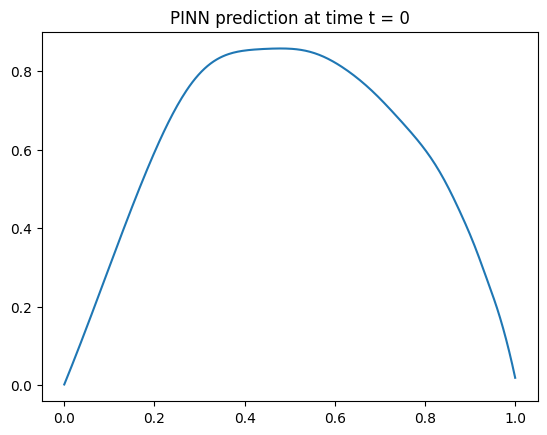

In [15]:
%matplotlib inline

n = 0
plt.plot(x_grid, u_hat[:,n])
plt.title(f"PINN prediction at time t = {n}")
plt.show()

In [16]:
model_best.eval()
x_init = torch.cat((x_grid,torch.zeros_like(x_grid)), dim = 1)
u_pinn_init = model_best(x_init.to(device)).cpu()
u_init = cfg.init_cond(x_grid)
print(x_init.shape, u_pinn_init.shape, u_init.shape)

torch.Size([300, 2]) torch.Size([300, 1]) torch.Size([300, 1])


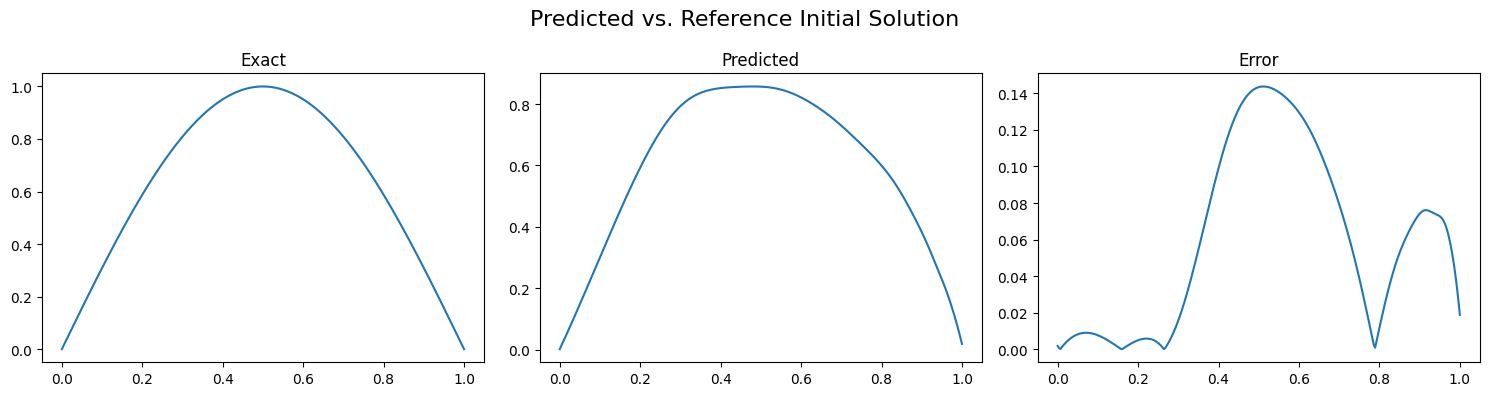

In [17]:
#First we plot the prediction of the initial solution and the exact initial solution
%matplotlib inline


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Predicted vs. Reference Initial Solution", fontsize=16)
# Plot each function in its own subplot
ax1.plot(x_grid, u_init)
ax1.set_title("Exact")

ax2.plot(x_grid, u_pinn_init.detach())
ax2.set_title("Predicted")

diff = torch.abs(u_init - u_pinn_init.detach())
ax3.plot(x_grid, diff)
ax3.set_title("Error")

plt.tight_layout()
plt.show()

> Finally, below is a moving plot to visualize how shocks develop in the Burger's equation over time. It can be seen that PINN captures the advection phenomena almost perfectly. Tuning the PINN parameters (e.g #No of epochs) will increase the accuracy, and reducing the diffusion coefficient $\nu$ will make the shock more apparent.

In [19]:
%matplotlib qt
# Plot setup
fig, ax = plt.subplots()
line, = ax.plot(x_grid, u_hat[:, 0])
ax.set_ylim(-0.1, 1.1)

for i in range(cfg.temporal_resolution):
    line.set_ydata(u_hat[:, i])
    ax.set_title(f"Time step {i}")
    plt.pause(0.05)

plt.show()
